![fish_poly_header.png](https://raw.githubusercontent.com/satishgunjal/images/master/fish_poly_header.png)


In this study I am using Python 3 environment to create a machine learning model to predict the weight of the fish based on the body measurement data of seven types of fish species. You can download the dataset from Kaggle. [Fish market](https://www.kaggle.com/aungpyaeap/fish-market)

I have documented the code and tried to explain every important concept or library I have used during this study. 

# Step 1: Import The Required Files
* numpy : Numpy is the core library for scientific computing in Python. It is used for working with arrays and matrices.
* pandas: Used for data manipulation and analysis
* matplotlib : It’s plotting library, and we are going to use it for data visualization
* seaborn : It is also data visualization library, based on matplotlib
* linear_model: Sklearn linear regression model
* train_test_split : helper function from Sklearn library for splitting the dataset
* sklearn.metrics : Library encapsulate functions to measure the model performance
* PolynomialFeatures : This used to generate polynomial features. In this study we are going to generate second degree features.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures

In [4]:
import requests

try:
    response = requests.get('https://raw.githubusercontent.com/satishgunjal/datasets/master/Fish.csv')
    response.raise_for_status()  # Check if the request was successful
    print("Successfully accessed the URL")
except requests.exceptions.RequestException as e:
    print(f"An error occurred: {e}")


Successfully accessed the URL


In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/satishgunjal/datasets/master/Fish.csv')
print('Dimension of dataset= ', df.shape)
df.head(5)

Dimension of dataset=  (159, 7)


,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340



# Step 2: Understand The Data
* There are total 159 rows(training samples) and 7 columns in dataset.
* Each column details are as below

| Column Name | Details
| ------------|--------------
| Species     | Species name of fish
| Weight      | Weight of fish in gram     
| Length1     | Vertical length in CM
| Length2     | Diagonal length in CM
| Length3     | Cross length in CM
| Height      | Height in CM
| Width       | Diagonal width in CM   

* Features/input values/independent variables are 'Species', 'Length1','Length2', 'Length3', 'Height' and 'Width'
* Target/output value/dependent variable is 'Weight'
* So, we have to estimate the weight of the fish based on its measurement values.

Let's change the name of columns lenght1,length2 and length3  as per the content of it.

In [6]:
df1 = df.rename(columns={'Length1':'VerticalLen','Length2':'DiagonalLen','Length3':'CrossLen'})
df1.sample(5)

,Species,Weight,VerticalLen,DiagonalLen,CrossLen,Height,Width
55,Whitefish,270.0,23.6,26.0,28.7,8.3804,4.2476
154,Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936
19,Bream,650.0,31.0,33.5,38.7,14.4738,5.7276
13,Bream,340.0,29.5,32.0,37.3,13.9129,5.0728
116,Perch,900.0,36.5,39.0,41.4,11.1366,7.4934


In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Species      159 non-null    object 
 1   Weight       159 non-null    float64
 2   VerticalLen  159 non-null    float64
 3   DiagonalLen  159 non-null    float64
 4   CrossLen     159 non-null    float64
 5   Height       159 non-null    float64
 6   Width        159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


# Step 3: Data Analysis Cleaning and Visualization

In [9]:
df2 = df1.drop(['VerticalLen', 'DiagonalLen', 'CrossLen'], axis =1) # Can also use axis = 'columns'
print('New dimension of dataset is= ', df2.shape)
df2.head(3)

New dimension of dataset is=  (159, 4)


,Species,Weight,Height,Width
0,Bream,242.0,11.5200,4.0200
1,Bream,290.0,12.4800,4.3056
2,Bream,340.0,12.3778,4.6961


## Visulization Using Pairplot

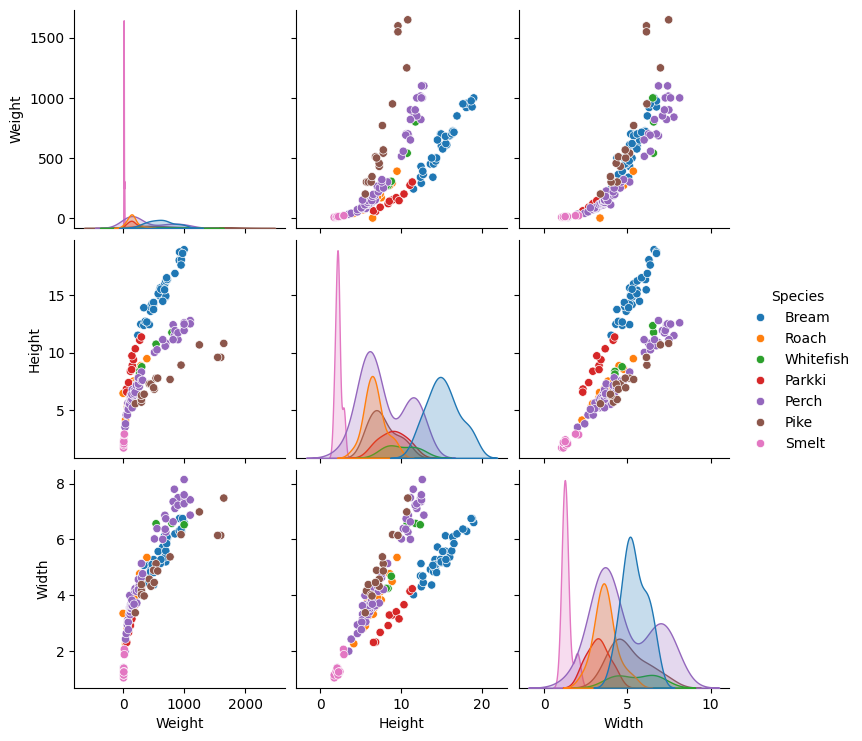

In [10]:
sns.pairplot(df2, kind = 'scatter', hue = 'Species')

From the above pair plot, we can see that there seems to be some correlations between  Height, Width and the Weight. Note that since we have multiple species the correlation between Height and Width of all species is not exactly linear with Weight.

Now, since we have the final dataset ready lets analyze and remove the outliers if any

## Outlier Detection and Removal

* Outlier is an extremely high or extremely low value in our data
* We use below formula to identify the outlier
  ```
    ( Greater than Q3 + 1.5 * IQR ) OR ( Lower than Q1 -1.5 * IQR )

    where,
    Q1  = First quartile
    Q3  = Third quartile
    IQR = Interquartile range (Q3 - Q1)
  ```

* We will use box plot for outlier visualization.
* Vertical line on the left side of box plot represent the 'min' value of dataset and vertical line on right side of box plot represent the 'max' value of dataset. Any value which is outside this range is outlier and represented by '*'

Lets write function for outlier detection

In [11]:
def outlier_detection(dataframe):
  """
  Find the outlier in given dataset. To get the index fo the outlier data, please input single column dataframe

  Input Parameters
  ----------------
  dataframe : single column dataframe

  Output Parameters
  -----------------
  outlier : Index of outlier training examples.
  """
  Q1 = dataframe.quantile(0.25)
  Q3 = dataframe.quantile(0.75)
  IQR = Q3 - Q1
  upper_end = Q3 + 1.5 * IQR
  lower_end = Q1 - 1.5 * IQR
  outlier = dataframe[(dataframe > upper_end) | (dataframe < lower_end)]
  return outlier

### Outlier detection based on Weight

Text(0.5, 1.0, 'Outlier Detection Based on Weight')

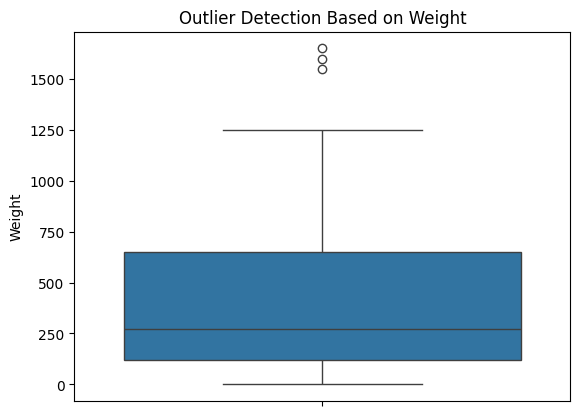

In [12]:
sns.boxplot(data= df2['Weight'] )
plt.title('Outlier Detection Based on Weight')

In [13]:
# 'Species' column contains categorical values, so using list slicing to iterate over all the columns except first one
for column in df2.columns[1:]:
    print('\nOutliers in column "%s" ' % column)
    outlier = outlier_detection(df2[column])
    print(outlier)


Outliers in column "Weight" 
142    1600.0
143    1550.0
144    1650.0
Name: Weight, dtype: float64

Outliers in column "Height" 
Series([], Name: Height, dtype: float64)

Outliers in column "Width" 
Series([], Name: Width, dtype: float64)


* For features Weight, VerticalLen and DiagonalLen index number 142, 143 and 144 are the outliers.
* For feature CrossLen index 144 is outlier
* For features Height and Width there are no outliers
* Important thing to note is, we haven't consider the individual fish species count and physical properties while finding the outliers. For e.g. Pike are bigger and Smelt are smaller fish species. We have 56 training examples for 'Perch' and only 6 training examples for 'Whitefish' fish species.
* Though we have small dataset, species wise outlier detection will help to make our model more accurate.

So lets find the outlier for each species.

In [14]:
#Lets create temp dataframe without 'Weight' feature for plotting the boxplot
df_temp = df2.drop(['Weight'], axis = 'columns')

### Outlier detection for Perch species

Text(0.5, 1.0, 'Outlier Detection For Pearch Species')

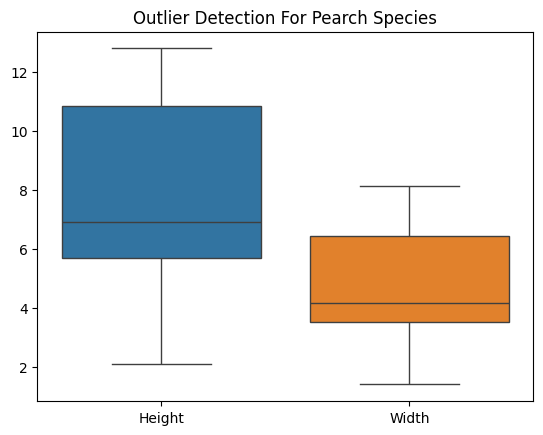

In [15]:
sns.boxplot(data= df_temp[df_temp.Species == 'Perch'] )
plt.title('Outlier Detection For Pearch Species')

In [16]:
df_Perch = df2[df2.Species == 'Perch']
for column in df_Perch.columns[1:]:
    print('\nOutliers in column "%s" ' % column)
    outlier = outlier_detection(df_Perch[column])
    print(outlier)


Outliers in column "Weight" 
Series([], Name: Weight, dtype: float64)

Outliers in column "Height" 
Series([], Name: Height, dtype: float64)

Outliers in column "Width" 
Series([], Name: Width, dtype: float64)


There are no outliers for 'Perch' fish species

### Outlier detection for Bream species

Text(0.5, 1.0, 'Outlier Detection For Bream Species')

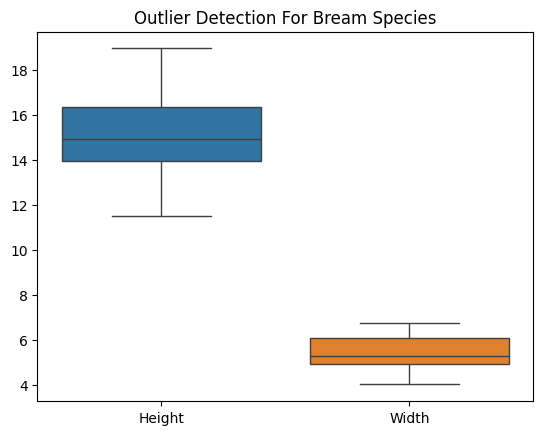

In [17]:
sns.boxplot(data= df_temp[df_temp.Species == 'Bream'] )
plt.title('Outlier Detection For Bream Species')

In [18]:
df_Bream = df2[df2.Species == 'Bream']
for column in df_Bream.columns[1:]:
    print('\nOutliers in column "%s" ' % column)
    outlier = outlier_detection(df_Bream[column])
    print(outlier)


Outliers in column "Weight" 
Series([], Name: Weight, dtype: float64)

Outliers in column "Height" 
Series([], Name: Height, dtype: float64)

Outliers in column "Width" 
Series([], Name: Width, dtype: float64)


There are no outliers for 'Pearch' species

### Outlier detection for Roach species

Text(0.5, 1.0, 'Outlier Detection For Roach Species')

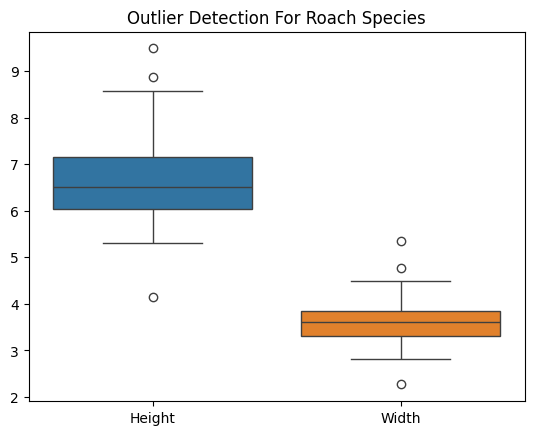

In [19]:
sns.boxplot(data= df_temp[df_temp.Species == 'Roach'] )
plt.title('Outlier Detection For Roach Species')

In [20]:
df_Roach = df2[df2.Species == 'Roach']
for column in df_Roach.columns[1:]:
    print('\nOutliers in column "%s" ' % column)
    outlier = outlier_detection(df_Roach[column])
    print(outlier)


Outliers in column "Weight" 
40      0.0
52    290.0
54    390.0
Name: Weight, dtype: float64

Outliers in column "Height" 
35    4.1472
52    8.8768
54    9.4850
Name: Height, dtype: float64

Outliers in column "Width" 
35    2.2680
53    4.7736
54    5.3550
Name: Width, dtype: float64


As you can see only row 54 and 35 are common across majority features, so we can safely remove them

### Outlier detection for Pike species

Text(0.5, 1.0, 'Outlier Detection For Pike Species')

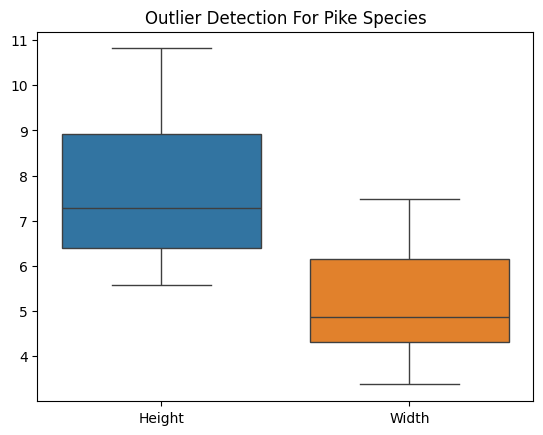

In [21]:
sns.boxplot(data= df_temp[df_temp.Species == 'Pike'] )
plt.title('Outlier Detection For Pike Species')

In [22]:
df_Pike = df2[df2.Species == 'Pike']
for column in df_Pike.columns[1:]:
    print('\nOutliers in column "%s" ' % column)
    outlier = outlier_detection(df_Pike[column])
    print(outlier)


Outliers in column "Weight" 
Series([], Name: Weight, dtype: float64)

Outliers in column "Height" 
Series([], Name: Height, dtype: float64)

Outliers in column "Width" 
Series([], Name: Width, dtype: float64)


No outlier for Pike species


### Outlier detection for Smelt species

Text(0.5, 1.0, 'Outlier Detection For Smelt Species')

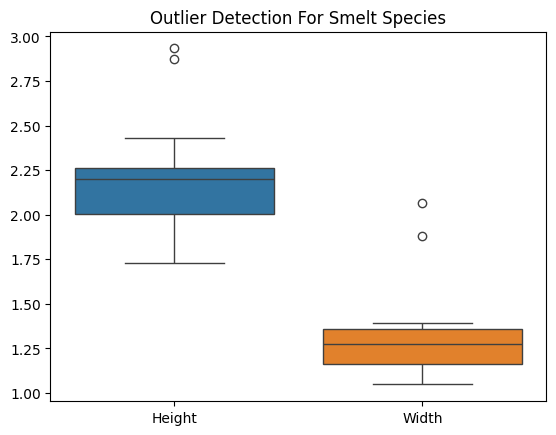

In [23]:
sns.boxplot(data= df_temp[df_temp.Species == 'Smelt'] )
plt.title('Outlier Detection For Smelt Species')

In [24]:
df_Smelt = df2[df2.Species == 'Smelt']
for column in df_Smelt.columns[1:]:
    print('\nOutliers in column "%s" ' % column)
    outlier = outlier_detection(df_Smelt[column])
    print(outlier)


Outliers in column "Weight" 
157    19.7
158    19.9
Name: Weight, dtype: float64

Outliers in column "Height" 
157    2.8728
158    2.9322
Name: Height, dtype: float64

Outliers in column "Width" 
157    2.0672
158    1.8792
Name: Width, dtype: float64


As you can see only rows 157 and 158 are common across multiple features, so we can safely remove them

### Outlier detection for Parkki species

Text(0.5, 1.0, 'Outlier Detection For Parkki Species')

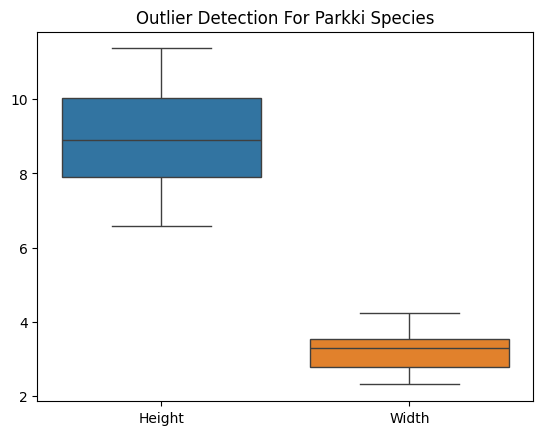

In [25]:
sns.boxplot(data= df_temp[df_temp.Species == 'Parkki'] )
plt.title('Outlier Detection For Parkki Species')

In [26]:
df_Parkki = df2[df2.Species == 'Parkki']
for column in df_Parkki.columns[1:]:
    print('\nOutliers in column "%s" ' % column)
    outlier = outlier_detection(df_Parkki[column])
    print(outlier)


Outliers in column "Weight" 
Series([], Name: Weight, dtype: float64)

Outliers in column "Height" 
Series([], Name: Height, dtype: float64)

Outliers in column "Width" 
Series([], Name: Width, dtype: float64)


No outliers for Parkki species

### Outlier detection for Whitefish species

Text(0.5, 1.0, 'Outlier Detection For Whitefish Species')

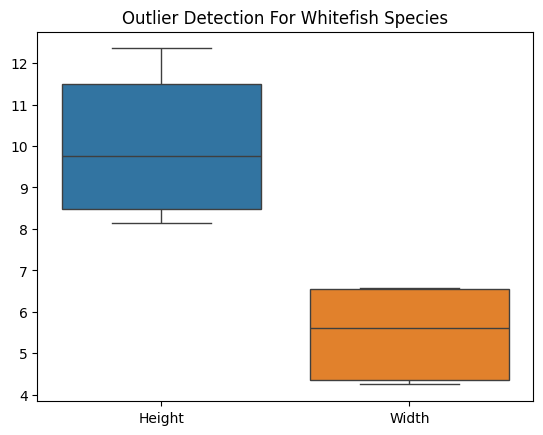

In [27]:
sns.boxplot(data= df_temp[df_temp.Species == 'Whitefish'] )
plt.title('Outlier Detection For Whitefish Species')

In [28]:
df_Whitefish = df2[df2.Species == 'Whitefish']
for column in df_Whitefish.columns[1:]:
    print('\nOutliers in column "%s" ' % column)
    outlier = outlier_detection(df_Whitefish[column])
    print(outlier)


Outliers in column "Weight" 
Series([], Name: Weight, dtype: float64)

Outliers in column "Height" 
Series([], Name: Height, dtype: float64)

Outliers in column "Width" 
Series([], Name: Width, dtype: float64)


No outlier for Whitefish species

### Dropping the outlier rows
* If we don't consider species specific measurement then outlier are 142, 143 and 144
* And as per species specific measurement outliers are 35, 54, 157 and 158
* Lets drop the species specific outliers only

In [29]:
df3 = df2.drop([35,54,157,158])
df3.shape

(155, 4)

## Using Domain Knowledge For Data Cleaning
Now lets use some common sense and find and remove the training data where weight of fish is 0 or negative

In [30]:
df3.isna().sum()



Species    0
Weight     0
Height     0
Width      0
dtype: int64

In [31]:
df3[df3.Weight <= 0]
df4 = df3.drop([40])
df4.shape

(154, 4)

In [32]:
dummies_species = pd.get_dummies(df4.Species) # store the dummy variables in 'dummies_species' dataframe
dummies_species.head(3) # To do get individual dummy value
df5 = pd.concat([df4, dummies_species],axis = 'columns')
df5.head(3)
df6 = df5.drop(['Species','Whitefish'], axis = 'columns')
df6.head(3)

,Weight,Height,Width,Bream,Parkki,Perch,Pike,Roach,Smelt
0,242.0,11.5200,4.0200,True,False,False,False,False,False
1,290.0,12.4800,4.3056,True,False,False,False,False,False
2,340.0,12.3778,4.6961,True,False,False,False,False,False


# Step 4: Build Machine Learning Model

In [33]:
X = df6[['Height', 'Width', 'Bream', 'Parkki' ,'Perch', 'Pike', 'Roach', 'Smelt']] # Or can use df6.iloc[:,[1,2,3,4,5,6,7,8]]
y = df6[['Weight']]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)
print('X_train dimension= ', X_train.shape)
print('X_test dimension= ', X_test.shape)
print('y_train dimension= ', y_train.shape)
print('y_train dimension= ', y_test.shape)

X_train dimension=  (123, 8)
X_test dimension=  (31, 8)
y_train dimension=  (123, 1)
y_train dimension=  (31, 1)


## Visualization Using Polynomial Function
* Since we have multiple species, the relation between features(Height, Width) and Weight is not linear
* Line won't be good fit to the given data and may result in under fitting.
* Lets visualize the data using multiple degrees of polynomial
* We are going to use below numpy functions to plot different degrees of polynomial functions
* **numpy.polyfit**: Used to fit a polynomial function of given degrees. It returns the coefficients (which minimizes the squared error) of the polynomial equation
  - This function takes three arguments to fit a polynomial function to given data. X values, Y values and degrees (1,2,3...n)
  - Polynomial equation of degree 1 is linear equation: **y = mx + b**
  - Polynomial equation of degree 2 is quadratic equation: **y = ax^2 + bx + c**
  - So polyfit function will return the coefficients of the polynomial equation. For linear equation coeff will be [m,b] and for quadratic equation coeff will be [a,b,c]
* **numpy.poly1d**: Is used to define the polynomial function using the coefficients returned by 'numpy.polyfit'
  - It takes polynomial coefficients as argument and construct a polynomial.
  - For e.g. if there are three coeff then it will construct quadratic equation
* **numpy.linspace**: Takes three arguments (start, stop and num) and generates evenly spaced values(same as 'num') within 'start' and 'stop' range
* Finaly to draw a polynomial function we will plot 'values' generated 'linspace' function on X axis and on Y axis 'poly_func' output for every 'values'

In [35]:
def polynomial_plot(feature, label):
  # Create 1D array. We can use 'squeeze' function to reduce the 2D array to 1D array
  x_coordinates = feature
  y_coordinates = np.squeeze(label)

 # Contruct first degree polynomial function
  linear_func = np.poly1d(np.polyfit(x_coordinates, y_coordinates, 1))
  # Contruct second degree polynomial function
  quadratic_func = np.poly1d(np.polyfit(x_coordinates, y_coordinates, 2))

  # Generate evenly spaced values
  values = np.linspace(x_coordinates.min(), x_coordinates.max(), len(x_coordinates))

  plt.scatter(x_coordinates,y_coordinates, color='blue')
  plt.plot(values, linear_func(values), color='cyan', linestyle='dashed', label='Linear Function')
  plt.plot(values, quadratic_func(values), color='red', label='Quadratic Function')
  plt.xlabel('%s From Test Data'%(feature.name))
  plt.ylabel('Weight')
  plt.rcParams["figure.figsize"] = (10,6) # Custom figure size in inches
  plt.legend()
  plt.title("Linear Vs Quadratic Function For Feature %s" % (feature.name))
  plt.show()

Lets plot first and second degree polynomical for feature 'Width'.

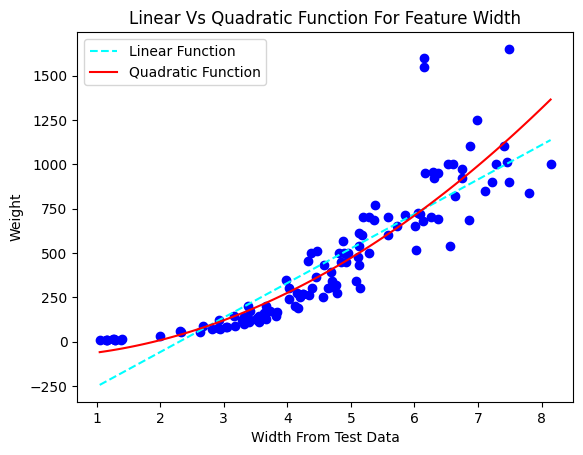

In [36]:
polynomial_plot(X_train.Width, y_train)

Lets plot first and second degree polynomical for feature 'Height'.

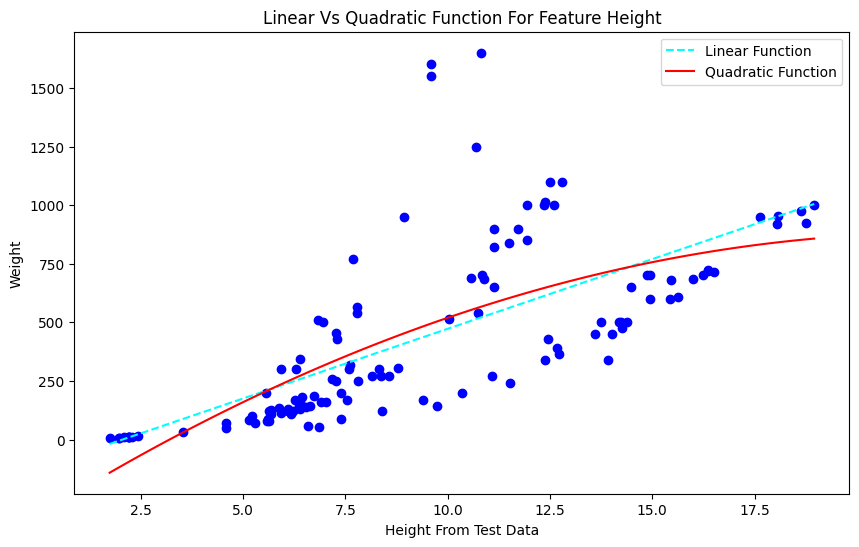

In [37]:
polynomial_plot(X_train.Height, y_train)

rom above first and second degree polynomial plots, it's clear that second degree polynomial feature will provide better fit.




In [38]:
poly = PolynomialFeatures(degree = 2)
X_poly = poly.fit_transform(X_train)
poly.fit(X_poly, y_train)

PolynomialFeatures()

## Ordinary Least Squares Algorithm

* Lets the train the model using Ordinary Least Squares Algorithm
* This is one of the most basic linear regression algorithm.
* Mathematical formula used by ordinary least square algorithm is as below,

   ![ordinary_least_squares_formlua.png](https://github.com/satishgunjal/images/blob/master/ordinary_least_squares_formlua_1.png?raw=true)
* The objective of Ordinary Least Square Algorithm is to minimize the residual sum of squares. Here the term residual means 'deviation of predicted value(Xw) from actual value(y)'
* Note that, problem with ordinary least square model is size of coefficients increase exponentially with increase in model complexity

In [39]:
lm = linear_model.LinearRegression()
lm.fit(X_poly, y_train)



LinearRegression()

## Understanding Training Results
* If training is successful then we get the result like above. Where all the default values used by LinearRgression() model are displayed. If required we can also pass these values in fit method. We are not going to change any of these values for now.


In [40]:
predictions = lm.predict(poly.fit_transform(X_test))
print('r2_score= ', metrics.r2_score(y_test, predictions))

r2_score=  0.9671772972934989


In [41]:
predictedWeight = pd.DataFrame(predictions, columns=['Predicted Weight']) # Create new dataframe of column'Predicted Weight'
actualWeight = pd.DataFrame(y_test)
actualWeight = actualWeight.reset_index(drop=True) # Drop the index so that we can concat it, to create new dataframe
df_actual_vs_predicted = pd.concat([actualWeight,predictedWeight],axis =1)
df_actual_vs_predicted.T

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
Weight,197.000000,800.000000,150.000000,5.900000,290.000000,145.000000,820.000000,7.000000,1000.00000,40.000000,...,85.000000,150.000000,110.00000,9.800000,130.000000,218.000000,300.000000,140.000000,850.000000,700.000000
Predicted Weight,189.903155,829.009451,179.234712,-26.372675,376.898685,134.096417,1007.767963,6.298816,1032.88805,12.599285,...,61.750568,141.725851,104.81456,9.961849,128.044275,232.252954,191.964533,132.049489,802.900758,705.066426


Text(0.5, 1.0, 'Weight From test Data Vs Weight Predicted By Model')

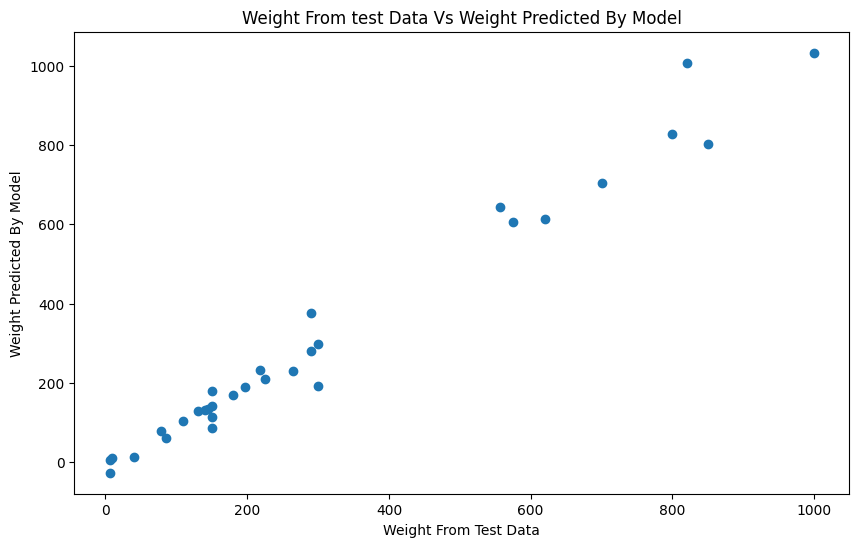

In [42]:
plt.scatter(y_test, predictions)
plt.xlabel('Weight From Test Data')
plt.ylabel('Weight Predicted By Model')
plt.rcParams["figure.figsize"] = (10,6) # Custom figure size in inches
plt.title("Weight From test Data Vs Weight Predicted By Model")

# Step 5: Evaluating the Model

Text(0.5, 1.0, 'Histogram of Residuals')

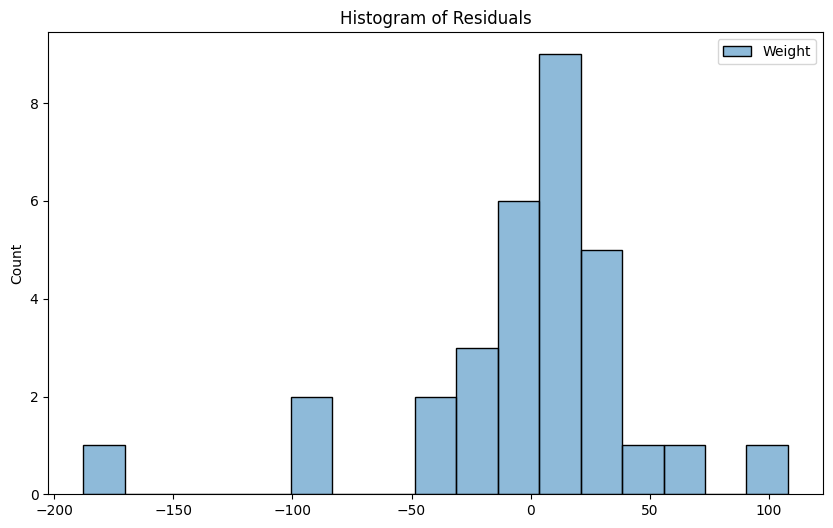

In [43]:
sns.histplot((y_test-predictions))
plt.rcParams["figure.figsize"] = (10,6) # Custom figure size in inches
plt.title("Histogram of Residuals")




# Conclusion
* As you can see from above results our model score is over 90%, which is very good.
* And there are no negative weight values
* So our approach of finding the outlier based on species and using second degree polynomial features worked!
